In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 7.5  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

dt = 0.05
t_data = np.arange(0, tf, dt)

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
def make_compressed_sheet(l, scaling=0.8):
# 2D honeycomb mesh
#l=3
    n_x = l+(l//2)+((l-1)//2)
    n_y = l+(l-1)
    xcrds = [(2 * i + (j % 2)) * 0.5 *scaling for j in range(n_y) for i in range(n_x)]
    ycrds = [np.sqrt(3) * j * 0.5 * scaling for j in range(n_y) for i in range(n_x)]

    # make cell_list for the sheet
    sheet = [cl.Cell(i, [x,y], -24.0, proliferating=False, division_time_generator=lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]

    # delete cells to make it circular - skip for now
    #del sheet[24]
    #del sheet[20]
    #del sheet[19]
    #del sheet[3*l+1+3+1]
    #del sheet[2*l+1+3]
    #del sheet[2*l+1+2]
    #del sheet[l+1]
    #del sheet[0]

    # find middle index, delete cell there and replace with proliferating one
    #m = n_x *(n_y//2)+ n_x//2
    #coords = list(sheet[m].position)
    #sheet[m] = cl.Cell(m, coords, -24.0, proliferating=True, division_time_generator=lambda t: 24+t)
    
    return sheet

In [6]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

# Global adaptive time-stepping for a globally compressed monolayer

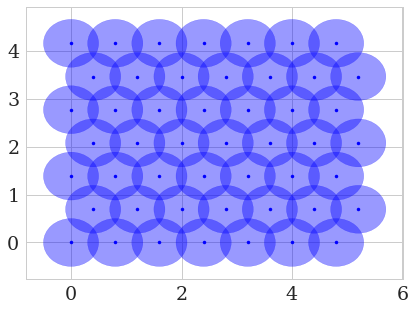

In [7]:
sheet = make_compressed_sheet(4)
plot_population(sheet)

In [8]:
# g'(s) for different force laws
gp_cubic = params_cubic['mu']*(s-rA)**2
rR = params_poly['rR']
muA = params_poly['muA']
gp_PWQ = 2*(muR/rR*(1-s/rR)-muA/rA*(1-s/rA))
gp_GLS = params_gls['mu']

print('Analytical stability bounds:')
print('Cubic '+ str(1.0/gp_cubic))
print('PWQ '+ str(1.0/gp_PWQ))
print('GLS '+ str(1.0/gp_GLS))


Analytical stability bounds:
Cubic 0.7017543859649122
PWQ 0.6639683340575724
GLS 0.5128205128205129


Initial step cubic 0.11319403099181234
Stability bound estimate cubic 0.1447426482393498
Initial step cubic 0.05062190958898207
Stability bound estimate cubic 0.2228197694338931
Initial step cubic 0.02263880619836247
Stability bound estimate cubic 0.13419173121172234
Initial step cubic [0.08751279 0.11318077 0.08751279]
Stability bound estimate cubic [0.15580497 2.47877824 0.2362118 ]
Initial step cubic [0.05061598 0.05061598 0.08751279]
Stability bound estimate cubic [0.21342032 2.49346205 0.23573927]
Initial step cubic [0.02263615 0.02263615 0.08751279]
Stability bound estimate cubic [0.16666715 1.14530356 0.23608556]


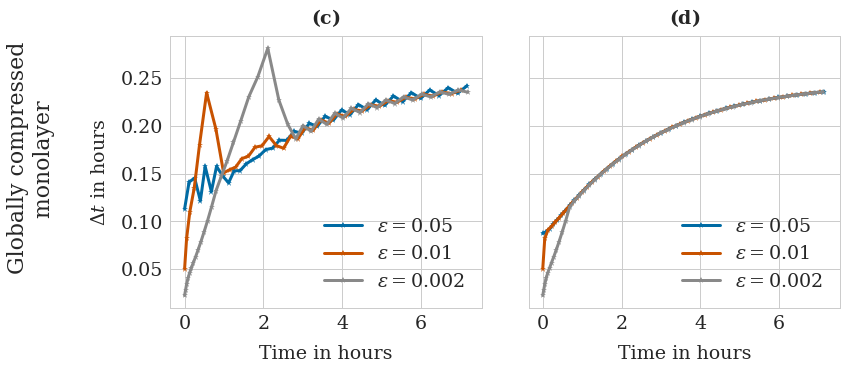

In [15]:
colors = [defcolors[0], defcolors[5], defcolors[6]]
# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

#ax1 No Jacobian - accuracy bound only
#ax1.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax1.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax1.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )

force = 'cubic'
epsilons = [0.05, 0.01, 0.002]

for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps,"eta":0.0001, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    #ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    ax1.plot(ts[:-2], dts[:-1],'-*', label='$\epsilon=$'+str(eps), color=colors[i])




ax1.legend()
ax1.set_title(r'$\bf{(c)}$')
ax1.set(xlabel='Time in hours')
ax1.set(ylabel='$\Delta t$ in hours')
#ax1.set(ylim=[-0.1, 1.2])
#ax1.text(3.7, 1.45, '$\epsilon=0.01$', fontsize=22)

#ax2 Using the Jacobian to obtain the stability bound
#ax2.plot(t_data, 1.0/gp_cubic*np.ones(len(t_data)), linestyle='--', color=defcolors[2])
#ax2.plot(t_data, 1.0/gp_PWQ*np.ones(len(t_data)), linestyle='--', color=colors['pw. quad.'] )
#ax2.plot(t_data, 1.0/gp_GLS*np.ones(len(t_data)), linestyle='--', color=colors['GLS'] )


for i, eps in enumerate(epsilons):
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": eps, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
    print('Initial step '+force + ' ' +str(dts[0]))
    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
    ax2.plot(ts[:-2], dts[:-1, 0],'-*', label='$\epsilon=$'+str(eps), color=colors[i])

ax2.set_title(r'$\bf{(d)}$')
ax2.legend()
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t$ in hours')
#ax2.set(ylim=[-0.1, 1.2])
#ax2.text(3.4, 1.45, '$\epsilon=0.001$', fontsize=22)

plt.savefig('global_adap_glob_mono.pdf', bbox_inches='tight')

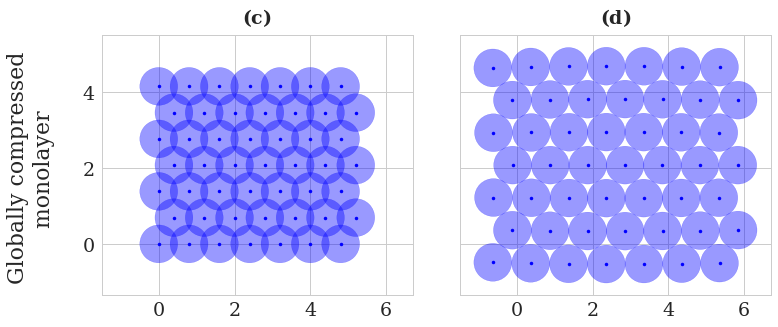

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})

n_cells = len(sheet)
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax1.add_patch(plt.Circle(sheet[i].position ,0.5,color='blue', alpha=0.4))
    ax1.plot(sheet[i].position[0], sheet[i].position[1], '.', color='blue')
    ax1.set_aspect('equal')
ax1.text(-4.0, -0.9, 'Globally compressed\n        monolayer', fontsize=22, rotation='vertical')
ax1.set_title(r'$\bf{(c)}$')


n_cells = len(history[-1])
for i in range(n_cells):
    #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
    ax2.add_patch(plt.Circle(history[-1][i].position ,0.5,color='blue', alpha=0.4))
    ax2.plot(history[-1][i].position[0], history[-1][i].position[1], '.', color='blue')
    ax2.set_aspect('equal')
ax2.set_title(r'$\bf{(d)}$')

    
plt.savefig('global_mono_plot.pdf', bbox_inches='tight')

# Dependence of initial step and stability bound on number of neigbors

In [ ]:
initial_step = {'cubic':[], 'pw. quad.': [], 'GLS': []}
stability_bounds = {'cubic':[], 'pw. quad.': [], 'GLS': []}
sl = [2, 3, 4, 5, 8, 10, 15]
for l in sl:
    sheet = make_compressed_sheet(l)
    
    for force in force_names:
    
        try:
            os.remove('step_sizes'+filename_ending[force]+'.txt')
        except FileNotFoundError:
            print('Nothing to delete.')
    
        ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file': True}, seed=seed)
        dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
        sbe = (dts[-2]+dts[-1])/2.0
        #print('Initial step '+force + ' ' +str(dts[0]))
        #print('Stability bound estimate '+force + ' ' +str(sbe))
        initial_step[force].append(dts[0])
        stability_bounds[force].append(sbe)
        


In [ ]:
n_cells = [(2*l-1)*(l+(l-1)//2+l//2) for l in sl]
for force in force_names:
    plt.plot(n_cells, stability_bounds[force], '-*', label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_s$ in hours')
#plt.savefig('dependence_stability_n_cells.pdf', bbox_inches='tight')

In [ ]:
for force in force_names:
    plt.plot(n_cells, initial_step[force], label=force, color=colors[force])

plt.legend()
plt.xlabel('Number of cells')
plt.ylabel('Numerical estimate of $\Delta t_0$ in hours')
plt.savefig('dependence_initial_step_n_cells.pdf', bbox_inches='tight')

# Plotting $\eta_k$ for a larger sheet

In [ ]:
sheet = make_compressed_sheet(4)

for force in force_names:
    
    try:
        os.remove('step_sizes'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')   
    try:
        os.remove('time_points'+filename_ending[force]+'.txt')
    except FileNotFoundError:
        print('Nothing to delete.')
        
    try:
        os.remove('AFs'+filename_ending[force]+'.txt')

    except FileNotFoundError:
        print('Nothing to delete.')
    
    ts, history = models_ef[force].simulate(sheet, t_data, params[force], {"eps": 0.01, "out": filename_ending[force], 'write_to_file' : True}, seed=seed)
    dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')
#    print('Initial step '+force + ' ' +str(dts[0]))
#    print('Stability bound estimate '+force + ' ' +str((dts[-2]+dts[-1])/2.0))
#    ts = np.loadtxt('time_points'+filename_ending[force]+'.txt')
    plt.plot(ts[:-1], dts,'-*', label=force, color=colors[force])
plt.legend()
plt.xlabel('Time in hours')
plt.ylabel('$\Delta t$ in hours')
#plt.savefig('adaptivity_38cells.pdf', bbox_inches='tight')
#plt.savefig('adaptivity_38cells.png', bbox_inches='tight')

In [ ]:
AFs = np.loadtxt('AFs'+filename_ending['pw. quad.']+'.txt')
sorted_AFs = np.sort(AFs)


In [ ]:
plt.plot(sorted_AFs[0,::-1], label='$t=\Delta t_0$')
plt.plot(sorted_AFs[1,::-1], label='$t=\Delta t_0+\Delta t_1$')
plt.plot(sorted_AFs[2,::-1], label='$t=\Delta t_0+\Delta t_1+\Delta t_2$')

plt.plot(sorted_AFs[-1,::-1], label='$t=t_f$')
plt.xlabel('k')
plt.ylabel('$|\eta_k|$, sorted decreasingly')
plt.legend()
plt.savefig('eta_k_pwq.pdf', bbox_inches='tight')